In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import warnings
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose


from sklearn.metrics import mean_squared_error

import sqlite3

In [22]:
path = 'data/Conventional'                     
all_files = glob.glob(os.path.join(path, "*.csv"))

df_from_each_file = (pd.read_csv(f) for f in all_files)
conventional_df = pd.concat(df_from_each_file, ignore_index=True)

In [23]:
conventional_df['Date'] = pd.to_datetime(conventional_df['Date'])
conventional_df.set_index('Date', inplace=True)

In [24]:
conventional_df = conventional_df.sort_index()

In [25]:
conventional_df.isnull().sum()

AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
dtype: int64

In [26]:
path = 'data/Organic'                     
all_files = glob.glob(os.path.join(path, "*.csv"))

df_from_each_file = (pd.read_csv(f) for f in all_files)
organic_df = pd.concat(df_from_each_file, ignore_index=True)

In [27]:
organic_df['Date'] = pd.to_datetime(organic_df['Date'])
organic_df.set_index('Date', inplace=True)

In [28]:
organic_df = organic_df.sort_index()
print(organic_df)

            AveragePrice  Total Volume       4046       4225      4770  \
Date                                                                     
2016-01-03          1.43     704100.50  124799.63  246580.95   7749.40   
2016-01-10          1.35     828670.59  113867.63  287590.19   8771.79   
2016-01-17          1.44     695341.42  115992.81  266824.72  13106.29   
2016-01-24          1.41     776964.55   99316.69  270980.88  12933.97   
2016-01-31          1.43     772077.20  108929.21  269687.52   5515.91   
2016-02-07          1.44     758795.10  101408.79  290813.54   8028.75   
2016-02-14          1.37     852463.31  102897.63  306235.69   6955.69   
2016-02-21          1.45     738856.92  104135.94  281188.89   8629.03   
2016-02-28          1.44     845011.63  110120.49  347488.78  10423.30   
2016-03-06          1.28    1012415.85  127184.88  351951.65   5698.20   
2016-03-13          1.29    1023655.87  132040.04  346341.46   6709.65   
2016-03-20          1.27    1045450.41

In [29]:
organic_df.isnull().sum()

AveragePrice    1
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
dtype: int64

In [30]:
organic_df.fillna(organic_df.mean(),inplace=True)

In [31]:
organic_df.isnull().sum()

AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
dtype: int64

In [32]:
print(organic_df)

            AveragePrice  Total Volume       4046       4225      4770  \
Date                                                                     
2016-01-03         1.430     704100.50  124799.63  246580.95   7749.40   
2016-01-10         1.350     828670.59  113867.63  287590.19   8771.79   
2016-01-17         1.440     695341.42  115992.81  266824.72  13106.29   
2016-01-24         1.410     776964.55   99316.69  270980.88  12933.97   
2016-01-31         1.430     772077.20  108929.21  269687.52   5515.91   
2016-02-07         1.440     758795.10  101408.79  290813.54   8028.75   
2016-02-14         1.370     852463.31  102897.63  306235.69   6955.69   
2016-02-21         1.450     738856.92  104135.94  281188.89   8629.03   
2016-02-28         1.440     845011.63  110120.49  347488.78  10423.30   
2016-03-06         1.280    1012415.85  127184.88  351951.65   5698.20   
2016-03-13         1.290    1023655.87  132040.04  346341.46   6709.65   
2016-03-20         1.270    1045450.41

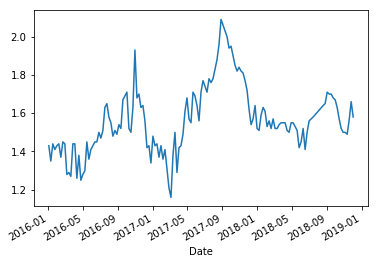

In [33]:
organic_df['AveragePrice'].plot()

In [34]:
organic_df = organic_df.drop(columns = ['Total Volume', '4046', '4225', '4770', 'Total Bags',
       'Small Bags', 'Large Bags', 'XLarge Bags'])

In [35]:
#To evaluate ARIMA model, X = dataframe, arima_order = (p,d,q)
def arima_error_calculation(X, arima_order):
	# split data-sets into training and test
	train_size = int(len(X) * 0.65)
	train = X[0:train_size]
    test = X[train_size:]
	history = [x for x in train]
	# use ARIMA to predict
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = arima_error_calculation(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.5f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.5f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 4)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(organic_df.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.00588
ARIMA(0, 0, 1) MSE=0.00294
ARIMA(0, 0, 2) MSE=0.00293
ARIMA(0, 0, 3) MSE=0.00265
ARIMA(0, 1, 0) MSE=0.00287
ARIMA(0, 1, 1) MSE=0.00306
ARIMA(0, 1, 2) MSE=0.00309
ARIMA(0, 1, 3) MSE=0.00317
ARIMA(0, 2, 0) MSE=0.00555
ARIMA(0, 2, 1) MSE=0.00294
ARIMA(1, 0, 0) MSE=0.00250
ARIMA(1, 0, 1) MSE=0.00266
ARIMA(1, 0, 2) MSE=0.00269
ARIMA(1, 1, 0) MSE=0.00297
ARIMA(1, 1, 1) MSE=0.00313
ARIMA(1, 2, 0) MSE=0.00468
ARIMA(1, 2, 1) MSE=0.00305
ARIMA(2, 0, 0) MSE=0.00260
ARIMA(2, 0, 1) MSE=0.00260
ARIMA(2, 0, 2) MSE=0.00270
ARIMA(2, 0, 3) MSE=0.00277
ARIMA(2, 1, 0) MSE=0.00295
ARIMA(2, 1, 1) MSE=0.00310
ARIMA(2, 2, 0) MSE=0.00382
ARIMA(2, 2, 1) MSE=0.00304
ARIMA(3, 0, 0) MSE=0.00261
ARIMA(3, 0, 1) MSE=0.00270
ARIMA(3, 0, 3) MSE=0.00258
ARIMA(3, 1, 0) MSE=0.00322
ARIMA(3, 1, 1) MSE=0.00316
ARIMA(3, 1, 2) MSE=0.00316
ARIMA(3, 2, 0) MSE=0.00341
Best ARIMA(1, 0, 0) MSE=0.00250


In [36]:
model = ARIMA(organic_df['AveragePrice'], order = (1, 0, 0))
results_ARIMA = model.fit()
predictions = round(results_ARIMA.predict(), 2)
preds = pd.DataFrame(list(zip(list(predictions.index),list(predictions))),columns=['Date',
                                                                                   'PredictedPrice']).set_index('Date')
predicted_df = pd.merge(organic_df[1:], preds, left_index=True, right_index=True)
predicted_df.head()

,AveragePrice,PredictedPrice
Date,,
2016-01-10,1.35,1.44
2016-01-17,1.44,1.37
2016-01-24,1.41,1.45
2016-01-31,1.43,1.43
2016-02-07,1.44,1.44


In [37]:

print("\tMean Squared Error:", mean_squared_error(predicted_df['AveragePrice'], predicted_df['PredictedPrice']))
print("\tRoot Mean Squared Error:", np.sqrt(mean_squared_error(predicted_df['AveragePrice'], 
                                                               predicted_df['PredictedPrice'])))

	Mean Squared Error: 0.006107601351351347
	Root Mean Squared Error: 0.07815114427410098


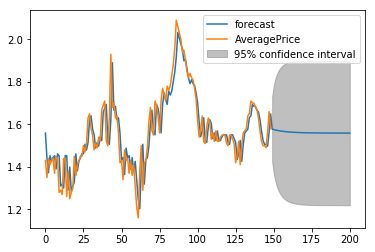

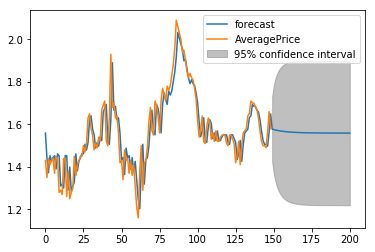

In [44]:
results_ARIMA.plot_predict(end=200)

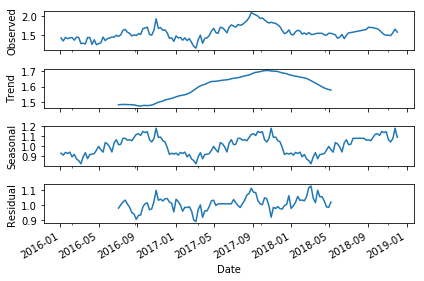

In [65]:
result = seasonal_decompose(organic_df, model='multiplicative',freq=52)
fig = result.plot()